# Cellar Track LSTM Text Classification


In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Conv1D, Dense, MaxPooling1D, GlobalMaxPooling1D, Embedding, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


## Data Prep

We'll read the Cellar Tracker data directly from Data.World.  This will take a bit to download.  Once it's downloaded, we can do some basic analysis on the dataset to see what we're dealing with.

In [3]:
df = pd.read_csv('https://query.data.world/s/r8VVStpwMgTZlScD_VyeGd6JUEX4fm')

Reviews with review/points assigned = 773497


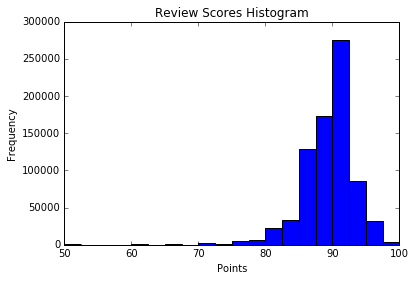

In [4]:
# Don't use rows where review/points or review/text is not provided
scored_df = df[df['review/points'].notnull()]
scored_df = scored_df[scored_df['review/text'].notnull()]

print('Reviews with review/points assigned = {}'.format(len(scored_df)))

plt.hist(scored_df['review/points'].values, bins = 20)
plt.title("Review Scores Histogram")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()

In [6]:
sized = scored_df.groupby('review/points').size()

count_dict = sized.to_dict()

sized_df = sized.to_frame()
#sized_df['review/points-pct'] = sized_df['review/points'].map(lambda s: s / sized.sum())

In [7]:
def help_determine_buckets():
    target = 77000
    accrued = 0

    bucket = 1
    buckets = { bucket: [] }

    for points in range(50, 101):     
            buckets[bucket].append(points)
            accrued += count_dict[points]

            if accrued >= target:        
                bucket += 1
                buckets[bucket] = []
                remaining = target


In [9]:
def assign_grade(review_points):
    if review_points == 100:
        return "AAA"
    elif review_points == 99:
        return "AA"
    elif review_points == 98:
        return "A"
    elif review_points == 97:
        return "BBB"
    elif review_points == 96:
        return "BB"
    elif review_points == 95:
        return "B"
    elif review_points == 94:
        return "CCC"
    elif review_points == 93:
        return "CC"
    elif review_points == 92:
        return "C"
    elif review_points == 91:
        return "DDD"    
    elif review_points == 90:
        return "DD"
    elif review_points == 89:
        return "D"
    elif review_points == 88:
        return "FFF"
    elif review_points == 87:
        return "FF"
    elif review_points == 86:
        return "F"
    else:
        return "ZZZ"    

In [10]:
scored_df['Grade'] = scored_df['review/points'].map(assign_grade)

In [11]:
X = scored_df['review/text'].values
y = scored_df['Grade'].values



In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print ('There are {} words across all reviews'.format(len(word_index)))

There are 152285 words across all reviews


In [ ]:
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 50

data = pad_sequences(X, maxlen= MAX_SEQUENCE_LENGTH)
labels = np_util.to_categorical(np.asarray(y))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', target.shape)

(x_train, x_test, y_train, y_test) = train_test_split(X, y, test_size = .20)